In [1]:
import os
import requests

from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

from openbabel import openbabel, pybel

import rdkit
from rdkit import Chem
from rdkit.Chem.rdchem import HybridizationType
from rdkit.Chem.rdchem import BondType as BT
from rdkit.Chem import AllChem, rdmolfiles, rdmolops, rdMolTransforms

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

import pickle

import warnings
warnings.filterwarnings('ignore')

In [2]:
from IPython.core.magic import register_cell_magic

@register_cell_magic
def skip(line, cell):
    return

In [3]:
### Setting all folders and filepaths to work on the project:
# The project was developed locally, so all files were downloaded to a target directory first
# The main subdirectories of the project will be *data* and *models*
# Data folder will contain all of our base datasets, as well as the directory of individual structures
DATA_PATH = os.path.join(os.getcwd(),"data")

TRAIN_FILE = os.path.join(DATA_PATH, "train.csv")
TEST_FILE = os.path.join(DATA_PATH, "test.csv")
STRUCTURES_FOLDER = os.path.join(DATA_PATH, "structures")
STRUCTURES_FILE = os.path.join(DATA_PATH, "structures.csv")
# MAGNETIC_SHIELD_TENSORS_FILE = os.path.join(DATA_PATH, "magnetic_shielding_tensors.csv")
# DIPOLE_MOMENTS_FILE = os.path.join(DATA_PATH, "dipole_moments.csv")
# MULLIKEN_CHARGES_FILE = os.path.join(DATA_PATH, "mulliken_charges.csv")
# POTENTIAL_ENERGY_FILE = os.path.join(DATA_PATH, "potential_energy.csv")
# SCALAR_COUPLING_CONTRIBUTIONS_FILE = os.path.join(DATA_PATH, "scalar_coupling_contributions.csv")

# Model folder will be the subdirectory where we will store all of our different models and training/tuning iterations of them
MODEL_FOLDER = os.path.join(os.getcwd(),"models")

Our project data sources are comprised of several .CSV files which contain information about molecular structures, as well as atom-level molecular properties and bond-level molecular properties.

The original Kaggle competition originally only provided the structural data and both train and test sets. However, closer to the end of the

Explicar que me restrinjo solo a los 3 csv iniciales de kaggle, ya que para el juego de test y comparación en la competición no hay datos disponibles. Por restricción de tiempo, no se opta por modelar cómo extender los datos adicionales al set de test. Y que aun así, se analizará y se añadiran datos complementarios cuando sea necesario.

In [4]:
# Once all directories have been stablished, let's load all the files in order to start working
structures_data = pd.read_csv(STRUCTURES_FILE)
train = pd.read_csv(TRAIN_FILE, index_col=0)
test = pd.read_csv(TEST_FILE, index_col=0)

## 2. Exploratory Data Analysis
Once we have loaded all the files into Pandas Dataframes, let's view in more detail the information that is available to us.
### 2.1 Train set information
The `train` dataset consists on the list of Scalar Coupling Constants for several pairs of atoms of a given molecule. First, we'll preview a few entries on the available dataset:

In [5]:
train.head(10)

,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant
id,,,,,
0,dsgdb9nsd_000001,1,0,1JHC,84.8076
1,dsgdb9nsd_000001,1,2,2JHH,-11.2570
2,dsgdb9nsd_000001,1,3,2JHH,-11.2548
3,dsgdb9nsd_000001,1,4,2JHH,-11.2543
4,dsgdb9nsd_000001,2,0,1JHC,84.8074
5,dsgdb9nsd_000001,2,3,2JHH,-11.2541
6,dsgdb9nsd_000001,2,4,2JHH,-11.2548
7,dsgdb9nsd_000001,3,0,1JHC,84.8093
8,dsgdb9nsd_000001,3,4,2JHH,-11.2543


As we can see, the `train` set contains several rows for each molecule, each row describing the interaction given a pair of atoms. 

In addition, we can see that there is an attribute called `type`. This attribute describes what kind of interaction does the scalar coupling represent. The `type` nomenclature consists of an alphanumeric code of 4 characters: "_nJAB_"
1. *n*: The first character represents the number of bonds between the first and second atoms in the pair of atoms.
2. *J*: The second character "J" is the symbol that represents the Scalar Coupling Constant, or J-coupling.
3. *A*: The third character represents the Chemical Symbol of the first atom in the pair.
4. *B*: The fourth character represents the Chemical Symbol of the second atom in the pair.

Now that we understand what the fields in the dataset are, let's take a look at how many rows of information we have in the `train` set, how many molecules are there, and the amount and different types of J-coupling constants that we have:

In [6]:
print(f"The number of rows in the train set is: {train.shape[0]}")
print(f'The number of unique molecules in the train set is: {train["molecule_name"].unique().shape[0]}')
print(f'The are {train["type"].unique().shape[0]} different types of Scalar Coupling Constants (J-coupling constants).')
print(f'The different types are: {train["type"].unique()}')

The number of rows in the train set is: 4659076
The number of unique molecules in the train set is: 85012
The are 8 different types of Scalar Coupling Constants (J-coupling constants).
The different types are: ['1JHC' '2JHH' '1JHN' '2JHN' '2JHC' '3JHH' '3JHC' '3JHN']


In addition to this basic information, let's find out what are the distributions for each of the types.

In [7]:
print(f'The number of rows for each type is:\n{train["type"].value_counts()}\n')
# Basic statistics for each type:
grouped_stats = train.groupby('type').agg({
    'scalar_coupling_constant': ['mean', 'median', 'std']
})
print(f'The basic statistics (mean, median and standard deviation) of the Scalar Coupling Constant for each type are:\n{grouped_stats}')

The number of rows for each type is:
type
3JHC    1511207
2JHC    1140867
1JHC     709133
3JHH     590529
2JHH     377988
3JHN     166613
2JHN     119059
1JHN      43680
Name: count, dtype: int64

The basic statistics (mean, median and standard deviation) of the Scalar Coupling Constant for each type are:
     scalar_coupling_constant                      
                         mean     median        std
type                                               
1JHC                94.973472  88.206000  18.290334
1JHN                47.492087  47.789400  10.897996
2JHC                -0.273447  -0.951282   4.520720
2JHH               -10.283040 -11.328000   3.983509
2JHN                 3.125678   2.017700   3.676290
3JHC                 3.688640   2.879000   3.075859
3JHH                 4.771004   3.687920   3.706132
3JHN                 0.991046   0.656221   1.320717


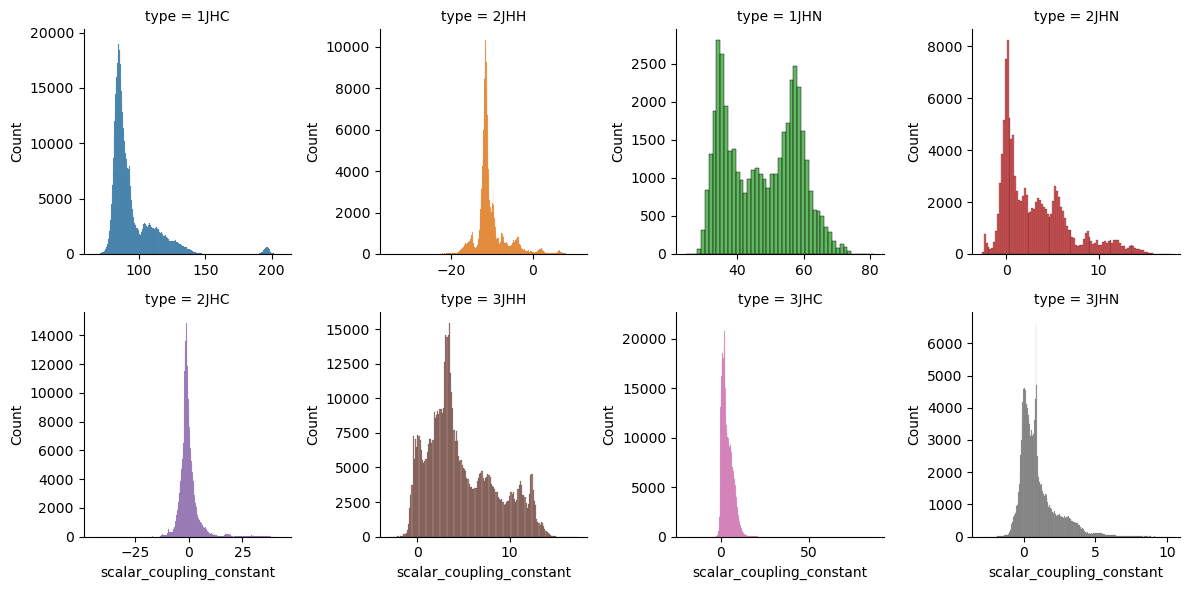

In [8]:
## Let's take a look at all the different constants distribution side by side
g = sns.FacetGrid(train, col="type", col_wrap = 4, sharey=False, sharex=False, hue="type")
g.map(sns.histplot, "scalar_coupling_constant")

As we can see, scalar coupling distributions vary for each type. Therefore, we'll take into account each type as a separate category in order to train our predictors.

## 2.2. Structures data
Let's also understand the scalar coupling distributions by seeing what's our molecule size distribution in the study dataset.

In [9]:
# Count the number of rows per molecule in train dataset
molecule_counts = structures_data.groupby('molecule_name').size().reset_index(name='atom_count')

# Distribution of atom counts in the structures dataset
print(molecule_counts['atom_count'].describe())

count    130789.000000
mean         18.035729
std           2.938573
min           3.000000
25%          16.000000
50%          18.000000
75%          20.000000
max          29.000000
Name: atom_count, dtype: float64


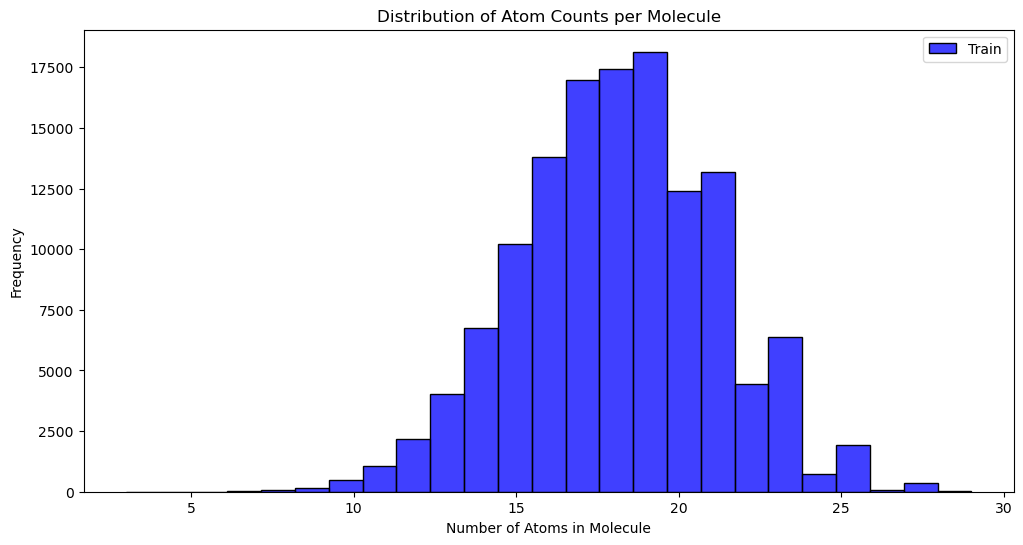

In [10]:
# Plot the distribution of atom counts for train and test
plt.figure(figsize=(12, 6))
sns.histplot(molecule_counts['atom_count'], bins=25, color='blue', label='Train')
plt.xlabel('Number of Atoms in Molecule')
plt.ylabel('Frequency')
plt.title('Distribution of Atom Counts per Molecule')
plt.legend()
plt.show()

As we can see, our dataset is comprised of molecules ranging from 3 to 29 atoms in size, where the majority of them span around the 18 atoms range. This can explain the amount of 2 and 3 bonds' distance interactions in the J-coupling distributions.

In [11]:
structures_data.head(10)

,molecule_name,atom_index,atom,x,y,z
0,dsgdb9nsd_000001,0,C,-0.012698,1.085804,0.008001
1,dsgdb9nsd_000001,1,H,0.002150,-0.006031,0.001976
2,dsgdb9nsd_000001,2,H,1.011731,1.463751,0.000277
3,dsgdb9nsd_000001,3,H,-0.540815,1.447527,-0.876644
4,dsgdb9nsd_000001,4,H,-0.523814,1.437933,0.906397
5,dsgdb9nsd_000002,0,N,-0.040426,1.024108,0.062564
6,dsgdb9nsd_000002,1,H,0.017257,0.012545,-0.027377
7,dsgdb9nsd_000002,2,H,0.915789,1.358745,-0.028758
8,dsgdb9nsd_000002,3,H,-0.520278,1.343532,-0.775543
9,dsgdb9nsd_000003,0,O,-0.034360,0.977540,0.007602


In [12]:
print(f"The number of rows in the structures dataset is: {structures_data.shape[0]}")
print(f'The number of unique molecules in the dataset is: {structures_data["molecule_name"].unique().shape[0]}')
print(f'The different atoms in the dataset are: {structures_data["atom"].unique()}')

The number of rows in the structures dataset is: 2358875
The number of unique molecules in the dataset is: 130789
The different atoms in the dataset are: ['C' 'H' 'N' 'O' 'F']


## 2.2 Test Set

In [13]:
test.head(10)

,molecule_name,atom_index_0,atom_index_1,type
id,,,,
4659076,dsgdb9nsd_000004,2,0,2JHC
4659077,dsgdb9nsd_000004,2,1,1JHC
4659078,dsgdb9nsd_000004,2,3,3JHH
4659079,dsgdb9nsd_000004,3,0,1JHC
4659080,dsgdb9nsd_000004,3,1,2JHC
4659081,dsgdb9nsd_000014,3,0,1JHC
4659082,dsgdb9nsd_000014,3,1,2JHC
4659083,dsgdb9nsd_000014,3,4,2JHH
4659084,dsgdb9nsd_000014,3,5,2JHH


In [14]:
print(f"The number of rows in the test set is: {test.shape[0]}")
print(f'The number of unique molecules in the train set is: {test["molecule_name"].unique().shape[0]}')
print(f'The are {test["type"].unique().shape[0]} different types of Scalar Coupling Constants (J-coupling constants).')
print(f'The different types are: {test["type"].unique()}')
print(f'The number of rows for each type is:\n{test["type"].value_counts()}\n')

The number of rows in the test set is: 2505190
The number of unique molecules in the train set is: 45777
The are 8 different types of Scalar Coupling Constants (J-coupling constants).
The different types are: ['2JHC' '1JHC' '3JHH' '2JHH' '3JHC' '3JHN' '1JHN' '2JHN']
The number of rows for each type is:
type
3JHC    811351
2JHC    613087
1JHC    380968
3JHH    317582
2JHH    203201
3JHN     90459
2JHN     64647
1JHN     23895
Name: count, dtype: int64



## 3. Feature engineering
In order to understand our data, first we'll group all the available data from the .CSV files by the level of the information.
That is, we'll merge all the atomic level data into the same object, and all the bond data into the same object.

### 3.1 Droping charged-atom molecular configurations.
In order to calculate some molecular data based on the conformation, there are some molecules in the dataset where the explicit atomic valence is greater than expected. This is due to some of the available molecules having positive or negative charges in on of their atoms.

Below, we define a function to calculate the 3D conformation of a molecule with rdkit in order to use the *.xyz files provided with structural data. 

In [15]:
%%skip
def generate_conformer(mol_smiles):
    """
    Generate a 3D conformer for a molecule from its SMILES representation.

    This function takes a SMILES string as input, generates a 3D molecular 
    structure, and returns the computed conformer. Hydrogen atoms are added 
    to the molecule, and the structure is optimized using the Universal Force Field (UFF).

    Args:
        mol_smiles (str): A SMILES string representing the molecular structure.

    Returns:
        RDKit.Chem.rdchem.Conformer: A 3D conformer object representing the 
                                     optimized molecular geometry.
    
    Raises:
        ValueError: If the input SMILES string cannot be converted to a molecule.
        RuntimeError: If the embedding or optimization process fails.
    """
    mol = Chem.AddHs(Chem.MolFromSmiles(mol_smiles))
    AllChem.EmbedMolecule(mol)
    AllChem.UFFOptimizeMolecule(mol)
    conformer = mol.GetConformer()
    return conformer

In [16]:
def generate_conformer_from_xyz(xyz_file_path):
    """
    Generate a 3D conformer for a molecule from an XYZ file.

    This function reads an XYZ file, creates an RDKit molecule with the 3D coordinates,
    and optimizes the geometry using the Universal Force Field (UFF).

    Args:
        xyz_file_path (str): Path to the XYZ file containing the molecule's geometry.

    Returns:
        tuple: A tuple containing:
            - rdkit.Chem.Mol: The RDKit molecule with an embedded conformer.
            - rdkit.Chem.rdchem.Conformer: The optimized 3D conformer object.

    Raises:
        RuntimeError: If a critical error occurs during the process.
    """
    # Load the molecule from the XYZ file
    try:
        # Read XYZ file into an RDKit molecule
        ob_molecule = next(pybel.readfile("xyz", xyz_file_path))
        
        mol_block = ob_molecule.write("mol")
        
        rdkit_mol = Chem.MolFromMolBlock(mol_block, removeHs=False)

        if rdkit_mol is None:
            raise ValueError("Invalid molecule from XYZ file")

        # Generate a 3D conformer and optimize using UFF
        AllChem.EmbedMolecule(rdkit_mol)
        AllChem.UFFOptimizeMolecule(rdkit_mol)

        # Return the optimized conformer
        conformer = rdkit_mol.GetConformer()
        
        return rdkit_mol, conformer

    except Exception as e:
        return None, None

In order to calculate a possible conformer, we'll be dropping all the molecules which contain a charged atom. Skipped molecules have been detected using the cell below. In order to simplify execution time, the cell is skipped in future executions as the list of skipped molecules will be loaded instead.


In [17]:
%%skip
molecule_files = os.listdir(STRUCTURES_FOLDER)

skipped_mols = []
conformers_dict = {}
rdkit_df = pd.DataFrame()

for molecule_file in molecule_files:

    xyz_file_path = os.path.join(STRUCTURES_FOLDER, molecule_file)
    rdkit_mol, conformer = generate_conformer_from_xyz(xyz_file_path)

    if rdkit_mol is None or conformer is None:
        skipped_mols.append(str(molecule_file[:-4]))
        continue
    
    # Compute charges
    rdkit_mol = Chem.AddHs(rdkit_mol)
    AllChem.ComputeGasteigerCharges(rdkit_mol)
    
    # Update conformers_dict
    centroid = rdkit.Chem.rdMolTransforms.ComputeCentroid(conformer, ignoreHs=True)
    conformers_dict[molecule_file[:-4]] = {
        "mol_name": molecule_file,
        "centroid_x": centroid.x, 
        "centroid_y": centroid.y, 
        "centroid_z": centroid.z
    }

    mol_data = {
        "molecule_name": [molecule_file[:-4] for atom in rdkit_mol.GetAtoms()],
        "atom index": [atom.GetIdx() for atom in rdkit_mol.GetAtoms()],  # Get the index of the atom
        "atom": [atom.GetSymbol() for atom in rdkit_mol.GetAtoms()],  # Get atomic symbol (e.g., N, H)
        "formal_charge": [atom.GetFormalCharge() for atom in rdkit_mol.GetAtoms()],  # Get formal charge
        "hybridization": [str(atom.GetHybridization()) for atom in rdkit_mol.GetAtoms()],  # Get hybridization
        "GasteigerCharge": [atom.GetProp('_GasteigerCharge') for atom in rdkit_mol.GetAtoms()]
    }
    mol_df = pd.DataFrame(mol_data)
    rdkit_df = pd.concat([rdkit_df, mol_df], axis=0)
        
 
with open("skipped_mols.pkl", "wb") as file:
    pickle.dump(skipped_mols, file)
print("Skipped mols saved")

conformers_df = pd.DataFrame(conformers_dict)
conformers_df.T.to_csv("conformers_df.csv", index=False)

rdkit_df.to_csv("rdkit_properties.csv", index=False)

# with open("rdkit_properties.pkl", "wb") as file:
#     pickle.dump(rdkit_df, file)
# print("rdkit properties df saved")

In [18]:
### Loading the list of meolecules to skip
with open("skipped_mols.pkl", "rb") as file:
    skipped_mols = pickle.load(file)
print(f"Molecule list to skip loaded. There are a total of {len(skipped_mols)} that will be dropped of the dataset.")

centroids = pd.read_csv("conformers_df.csv")
rdkit_df = pd.read_csv("rdkit_properties.csv")

Molecule list to skip loaded. There are a total of 7456 that will be dropped of the dataset.


In [19]:
centroids.head()

,mol_name,centroid_x,centroid_y,centroid_z
0,dsgdb9nsd_000001.xyz,-3.276490e-09,5.047205e-10,1.266899e-09
1,dsgdb9nsd_000002.xyz,3.812175e-03,4.380883e-04,2.949006e-01
2,dsgdb9nsd_000003.xyz,-6.607039e-05,4.041215e-01,0.000000e+00
3,dsgdb9nsd_000004.xyz,-1.279249e-08,3.312294e-07,-2.735905e-07
4,dsgdb9nsd_000005.xyz,5.456672e-01,-1.507562e-03,0.000000e+00


In [20]:
rdkit_df.head()

,molecule_name,atom index,atom,formal_charge,hybridization,GasteigerCharge
0,dsgdb9nsd_000001,0,C,0,SP3,-0.077558
1,dsgdb9nsd_000001,1,H,0,S,0.019389
2,dsgdb9nsd_000001,2,H,0,S,0.019389
3,dsgdb9nsd_000001,3,H,0,S,0.019389
4,dsgdb9nsd_000001,4,H,0,S,0.019389


In [21]:
structures_data = structures_data[~structures_data["molecule_name"].isin(skipped_mols)]
train = train[~train["molecule_name"].isin(skipped_mols)]
test = test[~test["molecule_name"].isin(skipped_mols)]

### 3.2. Adding atomic properties
In order to take into account more than just geometric information, we'll add some atomic properties to the dataset.
PubChem provides the Periodic Table and Element Pages to help users navigate the abundant chemical element data available within PubChem.
The data underlying the PubChem Periodic Table and Element Pages are freely available for download.

Before doing so, let's bear in mind that the additional data is only available for the train set. Therefore, we'll first splice the structural data (structures_data) into both Train (train_structures_data) and Test (test_structures_data) sets.

In [22]:
url = "https://pubchem.ncbi.nlm.nih.gov/rest/pug/periodictable/CSV"
periodic_table_properties = pd.read_csv(url)
periodic_table_properties.head()

,AtomicNumber,Symbol,Name,AtomicMass,CPKHexColor,ElectronConfiguration,Electronegativity,AtomicRadius,IonizationEnergy,ElectronAffinity,OxidationStates,StandardState,MeltingPoint,BoilingPoint,Density,GroupBlock,YearDiscovered
0,1,H,Hydrogen,1.008000,FFFFFF,1s1,2.20,120.0,13.598,0.754,"+1, -1",Gas,13.81,20.28,0.000090,Nonmetal,1766
1,2,He,Helium,4.002600,D9FFFF,1s2,NaN,140.0,24.587,NaN,0,Gas,0.95,4.22,0.000179,Noble gas,1868
2,3,Li,Lithium,7.000000,CC80FF,[He]2s1,0.98,182.0,5.392,0.618,+1,Solid,453.65,1615.00,0.534000,Alkali metal,1817
3,4,Be,Beryllium,9.012183,C2FF00,[He]2s2,1.57,153.0,9.323,NaN,+2,Solid,1560.00,2744.00,1.850000,Alkaline earth metal,1798
4,5,B,Boron,10.810000,FFB5B5,[He]2s2 2p1,2.04,192.0,8.298,0.277,+3,Solid,2348.00,4273.00,2.370000,Metalloid,1808


In [23]:
chosen_features = ["Symbol", "AtomicMass", "Electronegativity", "AtomicRadius", "IonizationEnergy"]
structures_data = pd.merge(left=structures_data, right=periodic_table_properties[chosen_features], how="inner", left_on="atom", right_on="Symbol")
structures_data.drop("Symbol", axis=1, inplace=True)
structures_data.head(10)

,molecule_name,atom_index,atom,x,y,z,AtomicMass,Electronegativity,AtomicRadius,IonizationEnergy
0,dsgdb9nsd_000001,0,C,-0.012698,1.085804,0.008001,12.011,2.55,170.0,11.260
1,dsgdb9nsd_000001,1,H,0.002150,-0.006031,0.001976,1.008,2.20,120.0,13.598
2,dsgdb9nsd_000001,2,H,1.011731,1.463751,0.000277,1.008,2.20,120.0,13.598
3,dsgdb9nsd_000001,3,H,-0.540815,1.447527,-0.876644,1.008,2.20,120.0,13.598
4,dsgdb9nsd_000001,4,H,-0.523814,1.437933,0.906397,1.008,2.20,120.0,13.598
5,dsgdb9nsd_000002,0,N,-0.040426,1.024108,0.062564,14.007,3.04,155.0,14.534
6,dsgdb9nsd_000002,1,H,0.017257,0.012545,-0.027377,1.008,2.20,120.0,13.598
7,dsgdb9nsd_000002,2,H,0.915789,1.358745,-0.028758,1.008,2.20,120.0,13.598
8,dsgdb9nsd_000002,3,H,-0.520278,1.343532,-0.775543,1.008,2.20,120.0,13.598
9,dsgdb9nsd_000003,0,O,-0.034360,0.977540,0.007602,15.999,3.44,152.0,13.618


In [24]:
# Adding rdkit properties to structure_data:
chosen_features = ["hybridization", "GasteigerCharge"]
structures_data[chosen_features] = rdkit_df[chosen_features]
structures_data.head()

,molecule_name,atom_index,atom,x,y,z,AtomicMass,Electronegativity,AtomicRadius,IonizationEnergy,hybridization,GasteigerCharge
0,dsgdb9nsd_000001,0,C,-0.012698,1.085804,0.008001,12.011,2.55,170.0,11.260,SP3,-0.077558
1,dsgdb9nsd_000001,1,H,0.002150,-0.006031,0.001976,1.008,2.20,120.0,13.598,S,0.019389
2,dsgdb9nsd_000001,2,H,1.011731,1.463751,0.000277,1.008,2.20,120.0,13.598,S,0.019389
3,dsgdb9nsd_000001,3,H,-0.540815,1.447527,-0.876644,1.008,2.20,120.0,13.598,S,0.019389
4,dsgdb9nsd_000001,4,H,-0.523814,1.437933,0.906397,1.008,2.20,120.0,13.598,S,0.019389


In [25]:
train_structures_data = structures_data[structures_data["molecule_name"].isin(train["molecule_name"])]
train_structures_data.head()

,molecule_name,atom_index,atom,x,y,z,AtomicMass,Electronegativity,AtomicRadius,IonizationEnergy,hybridization,GasteigerCharge
0,dsgdb9nsd_000001,0,C,-0.012698,1.085804,0.008001,12.011,2.55,170.0,11.260,SP3,-0.077558
1,dsgdb9nsd_000001,1,H,0.002150,-0.006031,0.001976,1.008,2.20,120.0,13.598,S,0.019389
2,dsgdb9nsd_000001,2,H,1.011731,1.463751,0.000277,1.008,2.20,120.0,13.598,S,0.019389
3,dsgdb9nsd_000001,3,H,-0.540815,1.447527,-0.876644,1.008,2.20,120.0,13.598,S,0.019389
4,dsgdb9nsd_000001,4,H,-0.523814,1.437933,0.906397,1.008,2.20,120.0,13.598,S,0.019389


In [26]:
test_structures_data = structures_data[structures_data["molecule_name"].isin(test["molecule_name"])]
test_structures_data.head()

,molecule_name,atom_index,atom,x,y,z,AtomicMass,Electronegativity,AtomicRadius,IonizationEnergy,hybridization,GasteigerCharge
12,dsgdb9nsd_000004,0,C,0.599539,0.000000,1.000000,12.011,2.55,170.0,11.260,SP,-0.123544
13,dsgdb9nsd_000004,1,C,-0.599539,0.000000,1.000000,12.011,2.55,170.0,11.260,SP,-0.123544
14,dsgdb9nsd_000004,2,H,-1.661639,0.000000,1.000000,1.008,2.20,120.0,13.598,S,0.123544
15,dsgdb9nsd_000004,3,H,1.661639,0.000000,1.000000,1.008,2.20,120.0,13.598,S,0.123544
74,dsgdb9nsd_000014,0,C,-0.008605,1.502038,-0.006812,12.011,2.55,170.0,11.260,SP3,-0.041838


As the dataset is high memory-demanding, we'll perform some downcasting in order to handle the datasets.
The following `reduce_mem_usage` function was widely used by different participants in the competition. For example, it can be found in several kernels as:
https://www.kaggle.com/code/artgor/artgor-utils
https://www.kaggle.com/code/todnewman/keras-neural-net-for-champs#Reduce-the-Memory-Usage

In [27]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                c_prec = df[col].apply(lambda x: np.finfo(x).precision).max()
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max and c_prec == np.finfo(np.float16).precision:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max and c_prec == np.finfo(np.float32).precision:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
                    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [28]:
reduced_mem_train = reduce_mem_usage(train)
reduced_mem_train_structures_data = reduce_mem_usage(train_structures_data)
reduced_mem_test = reduce_mem_usage(test)
reduced_mem_test_structures_data = reduce_mem_usage(test_structures_data)

# Saving the augmented structures_data:
reduced_mem_train_structures_data.to_csv(os.path.join(DATA_PATH, "augmented_train_structures.csv"))
reduced_mem_test_structures_data.to_csv((os.path.join(DATA_PATH, "augmented_test_structures.csv")))       

Mem. usage decreased to 142.19 Mb (29.2% reduction)
Mem. usage decreased to 133.91 Mb (6.7% reduction)
Mem. usage decreased to 58.49 Mb (35.0% reduction)
Mem. usage decreased to 72.06 Mb (6.7% reduction)


In [29]:
# train_df = reduced_mem_train.merge(reduced_mem_train_structures_data, left_on='atom_index_0', right_on='atom_index', suffixes=(None, "atom_index_0"))
print(reduced_mem_train.head())
print(reduced_mem_train.dtypes)

       molecule_name  atom_index_0  atom_index_1  type  \
id                                                       
0   dsgdb9nsd_000001             1             0  1JHC   
1   dsgdb9nsd_000001             1             2  2JHH   
2   dsgdb9nsd_000001             1             3  2JHH   
3   dsgdb9nsd_000001             1             4  2JHH   
4   dsgdb9nsd_000001             2             0  1JHC   

    scalar_coupling_constant  
id                            
0                    84.8076  
1                   -11.2570  
2                   -11.2548  
3                   -11.2543  
4                    84.8074  
molecule_name                object
atom_index_0                   int8
atom_index_1                   int8
type                         object
scalar_coupling_constant    float64
dtype: object


In [30]:
print(reduced_mem_train_structures_data.head())
print(reduced_mem_train_structures_data.dtypes)

      molecule_name  atom_index atom         x         y         z  \
0  dsgdb9nsd_000001           0    C -0.012698  1.085804  0.008001   
1  dsgdb9nsd_000001           1    H  0.002150 -0.006031  0.001976   
2  dsgdb9nsd_000001           2    H  1.011731  1.463751  0.000277   
3  dsgdb9nsd_000001           3    H -0.540815  1.447527 -0.876644   
4  dsgdb9nsd_000001           4    H -0.523814  1.437933  0.906397   

   AtomicMass  Electronegativity  AtomicRadius  IonizationEnergy  \
0      12.011               2.55         170.0            11.260   
1       1.008               2.20         120.0            13.598   
2       1.008               2.20         120.0            13.598   
3       1.008               2.20         120.0            13.598   
4       1.008               2.20         120.0            13.598   

  hybridization  GasteigerCharge  
0           SP3        -0.077558  
1             S         0.019389  
2             S         0.019389  
3             S         0.0193

In [31]:
### Este enfoque de aquí lo utilizaremos para juntar las propiedades de cada átomo en la línea que representa cada relación de acoplamiento.

def map_atom_info(df, structures_df, atom_idx):
    """
    Merges atomic structural information from `structures_df` into the main DataFrame `df` 
    based on the specified atom index, `atom_idx`.

    This function performs a left merge between `df` and `structures_df` on the columns
    `molecule_name` and the atom index specified by `atom_idx` in `df`. After merging, it
    renames the columns in `df` to uniquely identify them based on the atom index provided,
    and removes the redundant `atom_index` column.

    Parameters:
    -----------
    df : pandas.DataFrame
        The main DataFrame containing atom-level molecular information, including a molecule name and 
        atom index columns.
    
    structures_df : pandas.DataFrame
        The DataFrame containing structure information for each molecule, including 
        columns for `molecule_name`, `atom_index`, `atom`, `x`, `y`, and `z` coordinates.

    atom_idx : int
        The index of the atom in the molecule whose information will be merged into `df`.

    Returns:
    --------
    pandas.DataFrame
        A new DataFrame with atomic information from `structures_df` mapped to `df`, where
        the columns `atom`, `x`, `y`, and `z` have been renamed according to the specified 
        `atom_idx`, and the redundant `atom_index` column is dropped.
    """
    df = pd.merge(df, structures_df, how='left',
                  left_on=['molecule_name', f'atom_index_{atom_idx}'],
                  right_on=['molecule_name', 'atom_index'], suffixes=('_0', '_1'))
    df = df.rename(columns={'atom': f'atom_{atom_idx}',
                            'x': f'x_{atom_idx}', 'y': f'y_{atom_idx}', 'z': f'z_{atom_idx}'})
    df = df.drop(['atom_index'], axis=1)
    return df

reduced_train_df = map_atom_info(reduced_mem_train, reduced_mem_train_structures_data, 0)
train_df = map_atom_info(reduced_train_df, reduced_mem_train_structures_data, 1)
reduced_test_df = map_atom_info(reduced_mem_test, reduced_mem_test_structures_data, 0)
test_df = map_atom_info(reduced_test_df, reduced_mem_test_structures_data, 1)

### 3.3. Adding more geometrical data to the dataset.
J-couplings are heavily influenced by the geometrical configuration of the molecule. Therefore, we'll calculate some more features related to geometry to the dataset.

#### 3.3.1. Adding linear distances between each atom in a coupling pair.

In [32]:
train_df["nuclear_distance"] = np.linalg.norm(train_df[["x_0", "y_0", "z_0"]].values - train_df[["x_1", "y_1", "z_1"]].values, axis=1)
train_df["xx_distance"] = np.linalg.norm(train_df[["x_0"]].values - train_df[["x_1"]].values, axis=1)
train_df["yy_distance"] = np.linalg.norm(train_df[["y_0"]].values - train_df[["y_1"]].values, axis=1)
train_df["zz_distance"] = np.linalg.norm(train_df[["z_0"]].values - train_df[["z_1"]].values, axis=1)

test_df["nuclear_distance"] = np.linalg.norm(test_df[["x_0", "y_0", "z_0"]].values - test_df[["x_1", "y_1", "z_1"]].values, axis=1)
test_df["xx_distance"] = np.linalg.norm(test_df[["x_0"]].values - test_df[["x_1"]].values, axis=1)
test_df["yy_distance"] = np.linalg.norm(test_df[["y_0"]].values - test_df[["y_1"]].values, axis=1)
test_df["zz_distance"] = np.linalg.norm(test_df[["z_0"]].values - test_df[["z_1"]].values, axis=1)

#### 3.3.2. Calculating the center of each coupling pair

In [33]:
# Calculate the coupling center for train_df
train_df["coupling_center_x"] = (train_df["x_0"] + train_df["x_1"]) / 2
train_df["coupling_center_y"] = (train_df["y_0"] + train_df["y_1"]) / 2
train_df["coupling_center_z"] = (train_df["z_0"] + train_df["z_1"]) / 2

# Calculate the coupling center for test_df
test_df["coupling_center_x"] = (test_df["x_0"] + test_df["x_1"]) / 2
test_df["coupling_center_y"] = (test_df["y_0"] + test_df["y_1"]) / 2
test_df["coupling_center_z"] = (test_df["z_0"] + test_df["z_1"]) / 2

#### 3.3.3. Calculating the distance between the coupling center and the molecule centroid

In [34]:
centroids['molecule_name_clean'] = centroids['mol_name'].str.replace('.xyz', '', regex=False)
centroids.head()

train_df = train_df.merge(centroids, left_on="molecule_name", right_on="molecule_name_clean", how="inner")
train_df["pair_to_centroid_distance"] = np.linalg.norm(train_df[["centroid_x", "centroid_y", "centroid_z"]].values - train_df[["coupling_center_x", "coupling_center_y", "coupling_center_z"]].values, axis=1)
train_df = train_df.drop("molecule_name_clean", axis=1)

test_df = test_df.merge(centroids, left_on="molecule_name", right_on="molecule_name_clean", how="inner")
test_df["pair_to_centroid_distance"] = np.linalg.norm(test_df[["centroid_x", "centroid_y", "centroid_z"]].values - test_df[["coupling_center_x", "coupling_center_y", "coupling_center_z"]].values, axis=1)
test_df = test_df.drop("molecule_name_clean", axis=1)

In [35]:
train_df.head()

,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,AtomicMass_0,...,yy_distance,zz_distance,coupling_center_x,coupling_center_y,coupling_center_z,mol_name,centroid_x,centroid_y,centroid_z,pair_to_centroid_distance
0,dsgdb9nsd_000001,1,0,1JHC,84.8076,H,0.002150,-0.006031,0.001976,1.008,...,1.091835,0.006025,-0.005274,0.539886,0.004989,dsgdb9nsd_000001.xyz,-3.276490e-09,5.047205e-10,1.266899e-09,0.539935
1,dsgdb9nsd_000001,1,2,2JHH,-11.2570,H,0.002150,-0.006031,0.001976,1.008,...,1.469782,0.001700,0.506941,0.728860,0.001126,dsgdb9nsd_000001.xyz,-3.276490e-09,5.047205e-10,1.266899e-09,0.887821
2,dsgdb9nsd_000001,1,3,2JHH,-11.2548,H,0.002150,-0.006031,0.001976,1.008,...,1.453558,0.878620,-0.269332,0.720748,-0.437334,dsgdb9nsd_000001.xyz,-3.276490e-09,5.047205e-10,1.266899e-09,0.885030
3,dsgdb9nsd_000001,1,4,2JHH,-11.2543,H,0.002150,-0.006031,0.001976,1.008,...,1.443964,0.904421,-0.260832,0.715951,0.454187,dsgdb9nsd_000001.xyz,-3.276490e-09,5.047205e-10,1.266899e-09,0.887076
4,dsgdb9nsd_000001,2,0,1JHC,84.8074,H,1.011731,1.463751,0.000277,1.008,...,0.377947,0.007724,0.499516,1.274778,0.004139,dsgdb9nsd_000001.xyz,-3.276490e-09,5.047205e-10,1.266899e-09,1.369157


In [36]:
test_df.head()

,molecule_name,atom_index_0,atom_index_1,type,atom_0,x_0,y_0,z_0,AtomicMass_0,Electronegativity_0,...,yy_distance,zz_distance,coupling_center_x,coupling_center_y,coupling_center_z,mol_name,centroid_x,centroid_y,centroid_z,pair_to_centroid_distance
0,dsgdb9nsd_000004,2,0,2JHC,H,-1.661639,0.0,1.0,1.008,2.2,...,0.0,0.0,-0.531050,0.0,1.0,dsgdb9nsd_000004.xyz,-1.279249e-08,3.312294e-07,-2.735905e-07,1.132261
1,dsgdb9nsd_000004,2,1,1JHC,H,-1.661639,0.0,1.0,1.008,2.2,...,0.0,0.0,-1.130589,0.0,1.0,dsgdb9nsd_000004.xyz,-1.279249e-08,3.312294e-07,-2.735905e-07,1.509381
2,dsgdb9nsd_000004,2,3,3JHH,H,-1.661639,0.0,1.0,1.008,2.2,...,0.0,0.0,0.000000,0.0,1.0,dsgdb9nsd_000004.xyz,-1.279249e-08,3.312294e-07,-2.735905e-07,1.000000
3,dsgdb9nsd_000004,3,0,1JHC,H,1.661639,0.0,1.0,1.008,2.2,...,0.0,0.0,1.130589,0.0,1.0,dsgdb9nsd_000004.xyz,-1.279249e-08,3.312294e-07,-2.735905e-07,1.509381
4,dsgdb9nsd_000004,3,1,2JHC,H,1.661639,0.0,1.0,1.008,2.2,...,0.0,0.0,0.531050,0.0,1.0,dsgdb9nsd_000004.xyz,-1.279249e-08,3.312294e-07,-2.735905e-07,1.132261


### 3.4 Calculating angles and dihedral angles

In [37]:
centroids.head()

,mol_name,centroid_x,centroid_y,centroid_z,molecule_name_clean
0,dsgdb9nsd_000001.xyz,-3.276490e-09,5.047205e-10,1.266899e-09,dsgdb9nsd_000001
1,dsgdb9nsd_000002.xyz,3.812175e-03,4.380883e-04,2.949006e-01,dsgdb9nsd_000002
2,dsgdb9nsd_000003.xyz,-6.607039e-05,4.041215e-01,0.000000e+00,dsgdb9nsd_000003
3,dsgdb9nsd_000004.xyz,-1.279249e-08,3.312294e-07,-2.735905e-07,dsgdb9nsd_000004
4,dsgdb9nsd_000005.xyz,5.456672e-01,-1.507562e-03,0.000000e+00,dsgdb9nsd_000005


In [38]:
train_df.head()

,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,AtomicMass_0,...,yy_distance,zz_distance,coupling_center_x,coupling_center_y,coupling_center_z,mol_name,centroid_x,centroid_y,centroid_z,pair_to_centroid_distance
0,dsgdb9nsd_000001,1,0,1JHC,84.8076,H,0.002150,-0.006031,0.001976,1.008,...,1.091835,0.006025,-0.005274,0.539886,0.004989,dsgdb9nsd_000001.xyz,-3.276490e-09,5.047205e-10,1.266899e-09,0.539935
1,dsgdb9nsd_000001,1,2,2JHH,-11.2570,H,0.002150,-0.006031,0.001976,1.008,...,1.469782,0.001700,0.506941,0.728860,0.001126,dsgdb9nsd_000001.xyz,-3.276490e-09,5.047205e-10,1.266899e-09,0.887821
2,dsgdb9nsd_000001,1,3,2JHH,-11.2548,H,0.002150,-0.006031,0.001976,1.008,...,1.453558,0.878620,-0.269332,0.720748,-0.437334,dsgdb9nsd_000001.xyz,-3.276490e-09,5.047205e-10,1.266899e-09,0.885030
3,dsgdb9nsd_000001,1,4,2JHH,-11.2543,H,0.002150,-0.006031,0.001976,1.008,...,1.443964,0.904421,-0.260832,0.715951,0.454187,dsgdb9nsd_000001.xyz,-3.276490e-09,5.047205e-10,1.266899e-09,0.887076
4,dsgdb9nsd_000001,2,0,1JHC,84.8074,H,1.011731,1.463751,0.000277,1.008,...,0.377947,0.007724,0.499516,1.274778,0.004139,dsgdb9nsd_000001.xyz,-3.276490e-09,5.047205e-10,1.266899e-09,1.369157


In [39]:
import collections

def bfs_shortest_path(mol, idx_1, idx_2):
    """
    Finds the indexes of the atoms that belong to the shortest path between two atoms of the same molecule.

    Args:
        mol: rdkit Mol object.
        idx_1: The index of the first atom in the molecule from which calculate the path.
        idx_2: The index of the second atom in the molecule to which calculate the path.

    Returns:
        A list of node indices representing the shortest path, or None if no path exists.
    """
    
    queue = collections.deque([(idx_1, [idx_1])])
    visited = set([idx_1])

    while queue:
        current_node, path = queue.popleft()
        if current_node == idx_2:
            return path

        for neighbor in mol.GetAtomWithIdx(current_node).GetNeighbors():
            if neighbor.GetIdx() not in visited:
                visited.add(neighbor.GetIdx())
                queue.append((neighbor.GetIdx(), path + [neighbor.GetIdx()]))

    return None

In [40]:
def calculate_angle(row):
    """
    Calculates the angle between two atoms of the molecule given a distance of 2 bonds between them.
    """
    molecule_name = row["molecule_name"]
    idx_0 = row["atom_index_0"]
    idx_1 = row["atom_index_1"]

    molecule_file_path = os.path.join(STRUCTURES_FOLDER, molecule_name + ".xyz")
    mol, conformer = generate_conformer_from_xyz(molecule_file_path)

    if mol is None or conformer is None:
        return 0
    
    shortest_path = bfs_shortest_path(mol, idx_0, idx_1)
    
    if len(shortest_path) == 3:
        return rdkit.Chem.rdMolTransforms.GetAngleRad(conformer, shortest_path[0], shortest_path[1], shortest_path[2])

    return 0

In [41]:
def calculate_dihedral(row):
    """
    Calculates the angle between two atoms of the molecule given a distance of 2 bonds between them.
    """
    molecule_name = row["molecule_name"]
    idx_0 = row["atom_index_0"]
    idx_1 = row["atom_index_1"]

    molecule_file_path = os.path.join(STRUCTURES_FOLDER, molecule_name + ".xyz")
    mol, conformer = generate_conformer_from_xyz(molecule_file_path)

    if mol is None or conformer is None:
        return 0
    
    shortest_path = bfs_shortest_path(mol, idx_0, idx_1)

    if len(shortest_path) == 4:
        return rdkit.Chem.rdMolTransforms.GetDihedralRad(conformer, shortest_path[0], shortest_path[1], shortest_path[2], shortest_path[3])
        
    return 0

In [42]:
%%skip

## This block will only be executed once, since the calculations will be stored in files. In addition, it took 50 hours to compute all the angles.

train_df["angle"] = train_df.apply(calculate_angle, axis=1)
train_df["dihedral"] = train_df.apply(calculate_dihedral, axis=1)

test_df["angle"] = test_df.apply(calculate_angle, axis=1)
test_df["dihedral"] = test_df.apply(calculate_dihedral, axis=1)

train_df = reduce_mem_usage(train_df)
test_df = reduce_mem_usage(test_df)

train_df.to_csv("train_with_more_features.csv", index=False)
test_df.to_csv("test_with_more_features.csv", index=False)

In [43]:
train_df.head()

,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,AtomicMass_0,...,yy_distance,zz_distance,coupling_center_x,coupling_center_y,coupling_center_z,mol_name,centroid_x,centroid_y,centroid_z,pair_to_centroid_distance
0,dsgdb9nsd_000001,1,0,1JHC,84.8076,H,0.002150,-0.006031,0.001976,1.008,...,1.091835,0.006025,-0.005274,0.539886,0.004989,dsgdb9nsd_000001.xyz,-3.276490e-09,5.047205e-10,1.266899e-09,0.539935
1,dsgdb9nsd_000001,1,2,2JHH,-11.2570,H,0.002150,-0.006031,0.001976,1.008,...,1.469782,0.001700,0.506941,0.728860,0.001126,dsgdb9nsd_000001.xyz,-3.276490e-09,5.047205e-10,1.266899e-09,0.887821
2,dsgdb9nsd_000001,1,3,2JHH,-11.2548,H,0.002150,-0.006031,0.001976,1.008,...,1.453558,0.878620,-0.269332,0.720748,-0.437334,dsgdb9nsd_000001.xyz,-3.276490e-09,5.047205e-10,1.266899e-09,0.885030
3,dsgdb9nsd_000001,1,4,2JHH,-11.2543,H,0.002150,-0.006031,0.001976,1.008,...,1.443964,0.904421,-0.260832,0.715951,0.454187,dsgdb9nsd_000001.xyz,-3.276490e-09,5.047205e-10,1.266899e-09,0.887076
4,dsgdb9nsd_000001,2,0,1JHC,84.8074,H,1.011731,1.463751,0.000277,1.008,...,0.377947,0.007724,0.499516,1.274778,0.004139,dsgdb9nsd_000001.xyz,-3.276490e-09,5.047205e-10,1.266899e-09,1.369157


In [44]:
train_df.columns

Index(['molecule_name', 'atom_index_0', 'atom_index_1', 'type',
       'scalar_coupling_constant', 'atom_0', 'x_0', 'y_0', 'z_0',
       'AtomicMass_0', 'Electronegativity_0', 'AtomicRadius_0',
       'IonizationEnergy_0', 'hybridization_0', 'GasteigerCharge_0', 'atom_1',
       'x_1', 'y_1', 'z_1', 'AtomicMass_1', 'Electronegativity_1',
       'AtomicRadius_1', 'IonizationEnergy_1', 'hybridization_1',
       'GasteigerCharge_1', 'nuclear_distance', 'xx_distance', 'yy_distance',
       'zz_distance', 'coupling_center_x', 'coupling_center_y',
       'coupling_center_z', 'mol_name', 'centroid_x', 'centroid_y',
       'centroid_z', 'pair_to_centroid_distance'],
      dtype='object')

In [45]:
train_df.dtypes

molecule_name                 object
atom_index_0                    int8
atom_index_1                    int8
type                          object
scalar_coupling_constant     float64
atom_0                        object
x_0                          float64
y_0                          float64
z_0                          float64
AtomicMass_0                 float64
Electronegativity_0          float64
AtomicRadius_0               float64
IonizationEnergy_0           float64
hybridization_0               object
GasteigerCharge_0            float64
atom_1                        object
x_1                          float64
y_1                          float64
z_1                          float64
AtomicMass_1                 float64
Electronegativity_1          float64
AtomicRadius_1               float64
IonizationEnergy_1           float64
hybridization_1               object
GasteigerCharge_1            float64
nuclear_distance             float64
xx_distance                  float64
y

In [46]:
train_df = pd.read_csv(os.path.join(DATA_PATH, "train_with_more_features.csv"))
test_df = pd.read_csv(os.path.join(DATA_PATH,"test_with_more_features.csv"))

In [47]:
train_df.dtypes

molecule_name                 object
atom_index_0                   int64
atom_index_1                   int64
type                          object
scalar_coupling_constant     float64
atom_0                        object
x_0                          float64
y_0                          float64
z_0                          float64
AtomicMass_0                 float64
Electronegativity_0          float64
AtomicRadius_0               float64
IonizationEnergy_0           float64
hybridization_0               object
GasteigerCharge_0            float64
atom_1                        object
x_1                          float64
y_1                          float64
z_1                          float64
AtomicMass_1                 float64
Electronegativity_1          float64
AtomicRadius_1               float64
IonizationEnergy_1           float64
hybridization_1               object
GasteigerCharge_1            float64
nuclear_distance             float64
xx_distance                  float64
y

In [48]:
target_column = "scalar_coupling_constant"
numerical_columns_0 = ["x_0", "y_0", "z_0", "AtomicMass_0", "Electronegativity_0", "AtomicRadius_0", "IonizationEnergy_0", "GasteigerCharge_0"]
numerical_columns_1 = ["x_1", "y_1", "z_1", "AtomicMass_1", "Electronegativity_1", "AtomicRadius_1", "IonizationEnergy_1", "GasteigerCharge_1"]
numerical_columns_2 = ["nuclear_distance", "xx_distance", "yy_distance", "zz_distance", "coupling_center_x", "coupling_center_z", "centroid_x", "centroid_y", "centroid_z", "pair_to_centroid_distance", "dihedral", "angle"]
numerical_cols = numerical_columns_0 + numerical_columns_1 + numerical_columns_2

In [49]:
train_df.describe()

,atom_index_0,atom_index_1,scalar_coupling_constant,x_0,y_0,z_0,AtomicMass_0,Electronegativity_0,AtomicRadius_0,IonizationEnergy_0,...,zz_distance,coupling_center_x,coupling_center_y,coupling_center_z,centroid_x,centroid_y,centroid_z,pair_to_centroid_distance,angle,dihedral
count,4.385261e+06,4.385261e+06,4.385261e+06,4.385261e+06,4.385261e+06,4.385261e+06,4.385261e+06,4.385261e+06,4385261.0,4.385261e+06,...,4.385261e+06,4.385261e+06,4.385261e+06,4.385261e+06,4.385261e+06,4.385261e+06,4.385261e+06,4.385261e+06,4.385261e+06,4.385261e+06
mean,1.336376e+01,5.884282e+00,1.593764e+01,9.990660e-02,-2.286552e-01,4.793322e-02,1.008000e+00,2.200000e+00,120.0,1.359800e+01,...,1.127954e+00,9.535229e-02,-3.165299e-01,6.306853e-02,5.747384e-02,2.293597e-02,5.644136e-05,2.391110e+00,6.901433e-01,2.219245e-03
std,3.271675e+00,5.008882e+00,3.496967e+01,1.757319e+00,2.121695e+00,1.565059e+00,3.943846e-11,1.709610e-11,0.0,8.679991e-10,...,7.904770e-01,1.465763e+00,1.806113e+00,1.242964e+00,2.946237e-01,1.941602e-01,1.773972e-01,1.213303e+00,9.439277e-01,1.357011e+00
min,1.000000e+00,0.000000e+00,-4.476050e+01,-9.234889e+00,-9.933938e+00,-8.909428e+00,1.008000e+00,2.200000e+00,120.0,1.359800e+01,...,0.000000e+00,-9.226929e+00,-9.403067e+00,-8.702419e+00,-1.250119e+00,-8.174291e-01,-9.587874e-01,1.147676e-02,0.000000e+00,-3.141593e+00
25%,1.100000e+01,2.000000e+00,-2.639660e-01,-9.562194e-01,-1.853883e+00,-9.622521e-01,1.008000e+00,2.200000e+00,120.0,1.359800e+01,...,5.031467e-01,-6.720305e-01,-1.485444e+00,-6.134194e-01,-1.354289e-01,-1.001825e-01,-1.099686e-01,1.426068e+00,0.000000e+00,0.000000e+00
50%,1.300000e+01,5.000000e+00,2.298650e+00,1.296252e-01,-2.970474e-01,4.278513e-03,1.008000e+00,2.200000e+00,120.0,1.359800e+01,...,9.612673e-01,1.225213e-01,-3.627984e-01,2.204582e-02,4.455935e-02,1.492125e-02,-1.010939e-03,2.192229e+00,0.000000e+00,0.000000e+00
75%,1.600000e+01,8.000000e+00,7.386130e+00,1.214901e+00,1.749146e+00,1.032727e+00,1.008000e+00,2.200000e+00,120.0,1.359800e+01,...,1.699653e+00,9.657986e-01,7.785663e-01,7.303027e-01,2.451746e-01,1.411399e-01,1.091225e-01,3.161304e+00,1.906367e+00,0.000000e+00
max,2.800000e+01,2.800000e+01,2.077090e+02,9.382240e+00,1.018196e+01,7.659297e+00,1.008000e+00,2.200000e+00,120.0,1.359800e+01,...,3.718301e+00,8.901567e+00,9.651190e+00,7.216938e+00,1.572860e+00,1.121537e+00,9.331921e-01,1.111767e+01,3.141593e+00,3.141593e+00


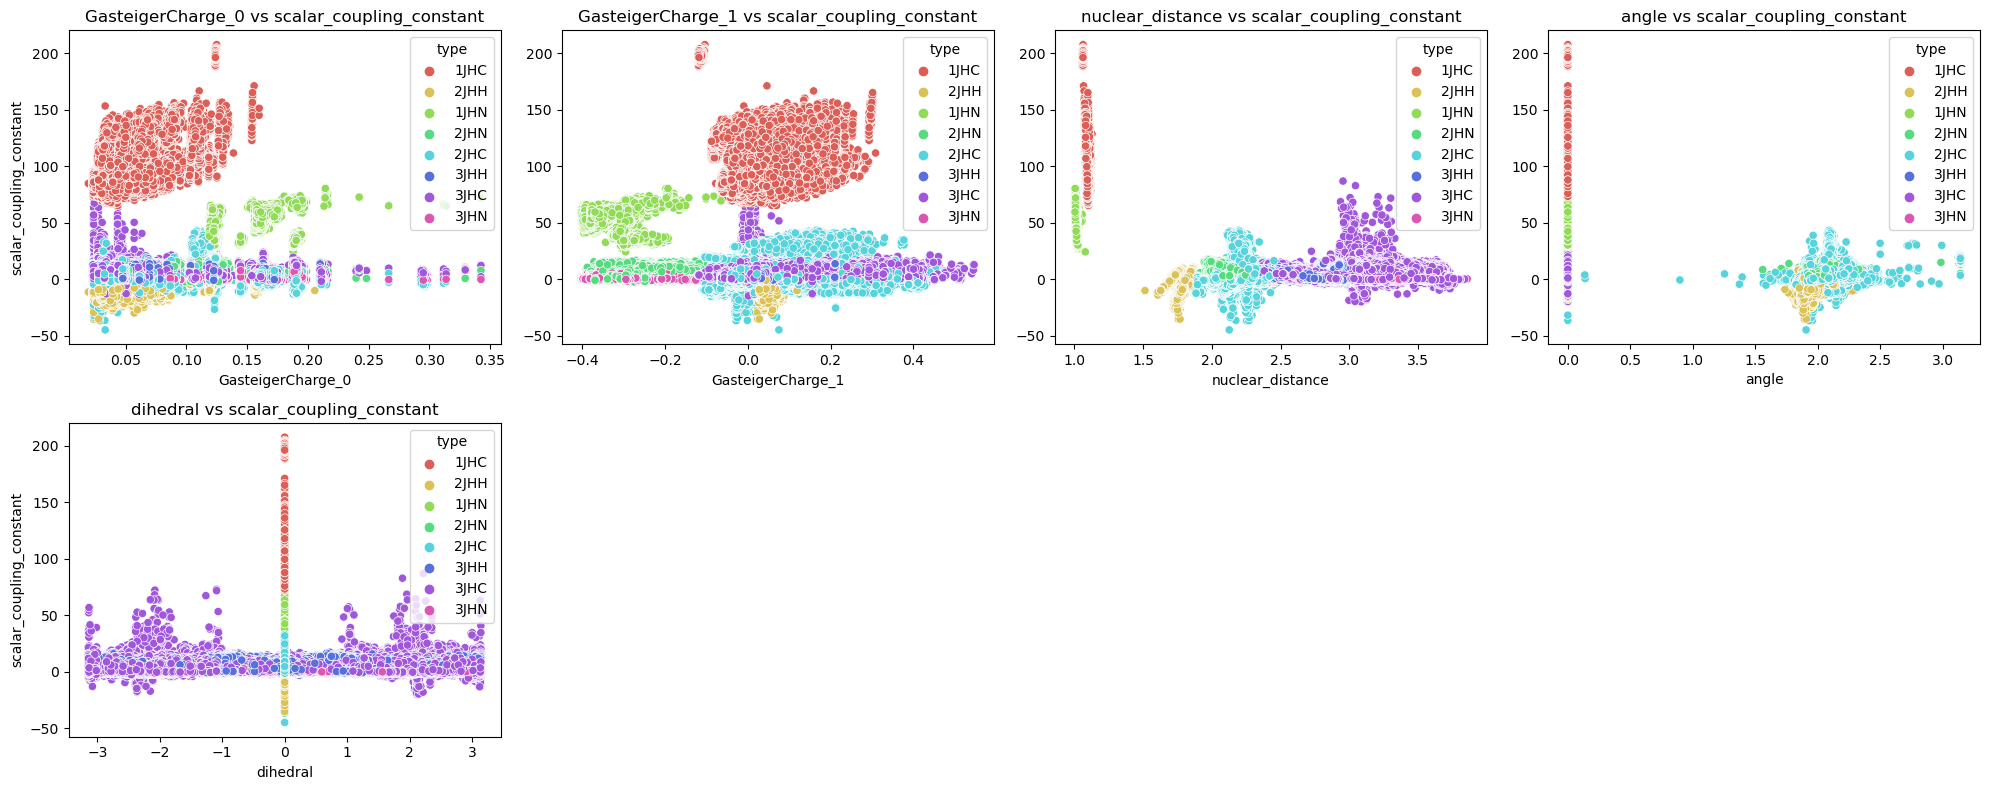

In [52]:
# %%skip
import seaborn as sns
import matplotlib.pyplot as plt

numerical_cols = ["GasteigerCharge_0", "GasteigerCharge_1", "nuclear_distance", "angle", "dihedral"]

n_cols = 4 
n_rows = (len(numerical_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

for i, column in enumerate(numerical_cols):
    sns.scatterplot(data=train_df, x=column, y=target_column, ax=axes[i], hue="type", palette="hls", legend=True)
    axes[i].set_title(f"{column} vs {target_column}")
    axes[i].set_xlabel(column)
    
    if i % n_cols != 0: 
        axes[i].set_ylabel('')
    else:
        axes[i].set_ylabel(target_column)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [53]:
J_types = train_df["type"].unique()
J_types

array(['1JHC', '2JHH', '1JHN', '2JHN', '2JHC', '3JHH', '3JHC', '3JHN'],
      dtype=object)

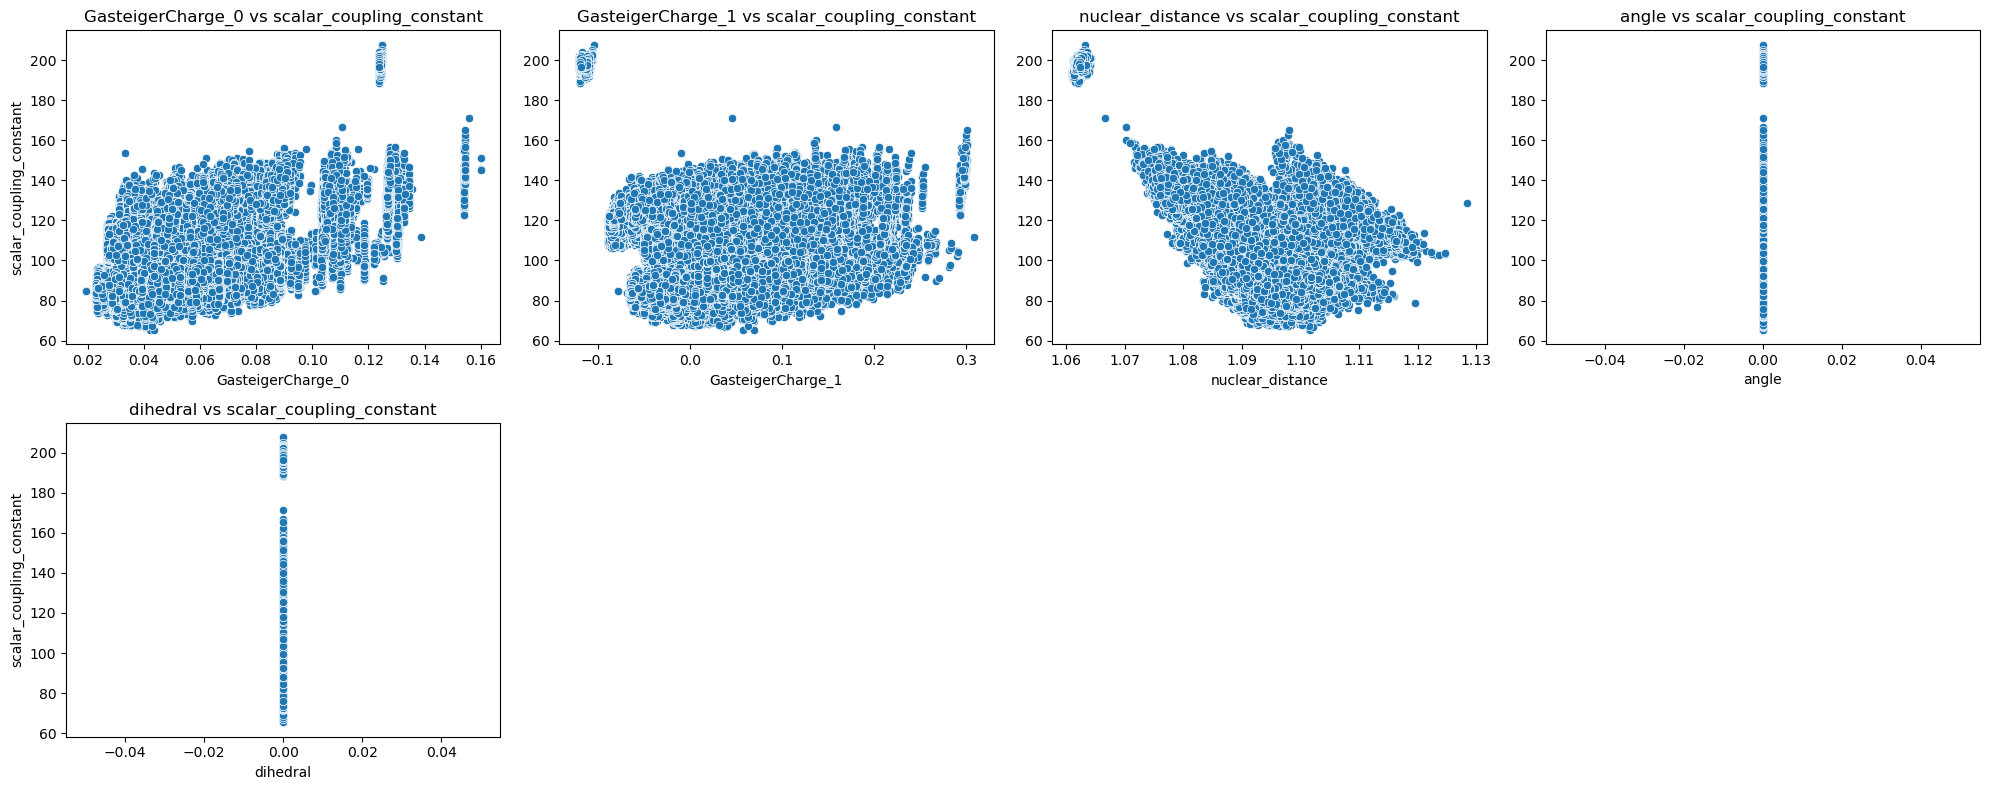

In [54]:
n_cols = 4 
n_rows = (len(numerical_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

for i, column in enumerate(numerical_cols):
    sns.scatterplot(data=train_df[train_df["type"] == J_types[0]], x=column, y=target_column, ax=axes[i])
    axes[i].set_title(f"{column} vs {target_column}")
    axes[i].set_xlabel(column)
    
    if i % n_cols != 0: 
        axes[i].set_ylabel('')
    else:
        axes[i].set_ylabel(target_column)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

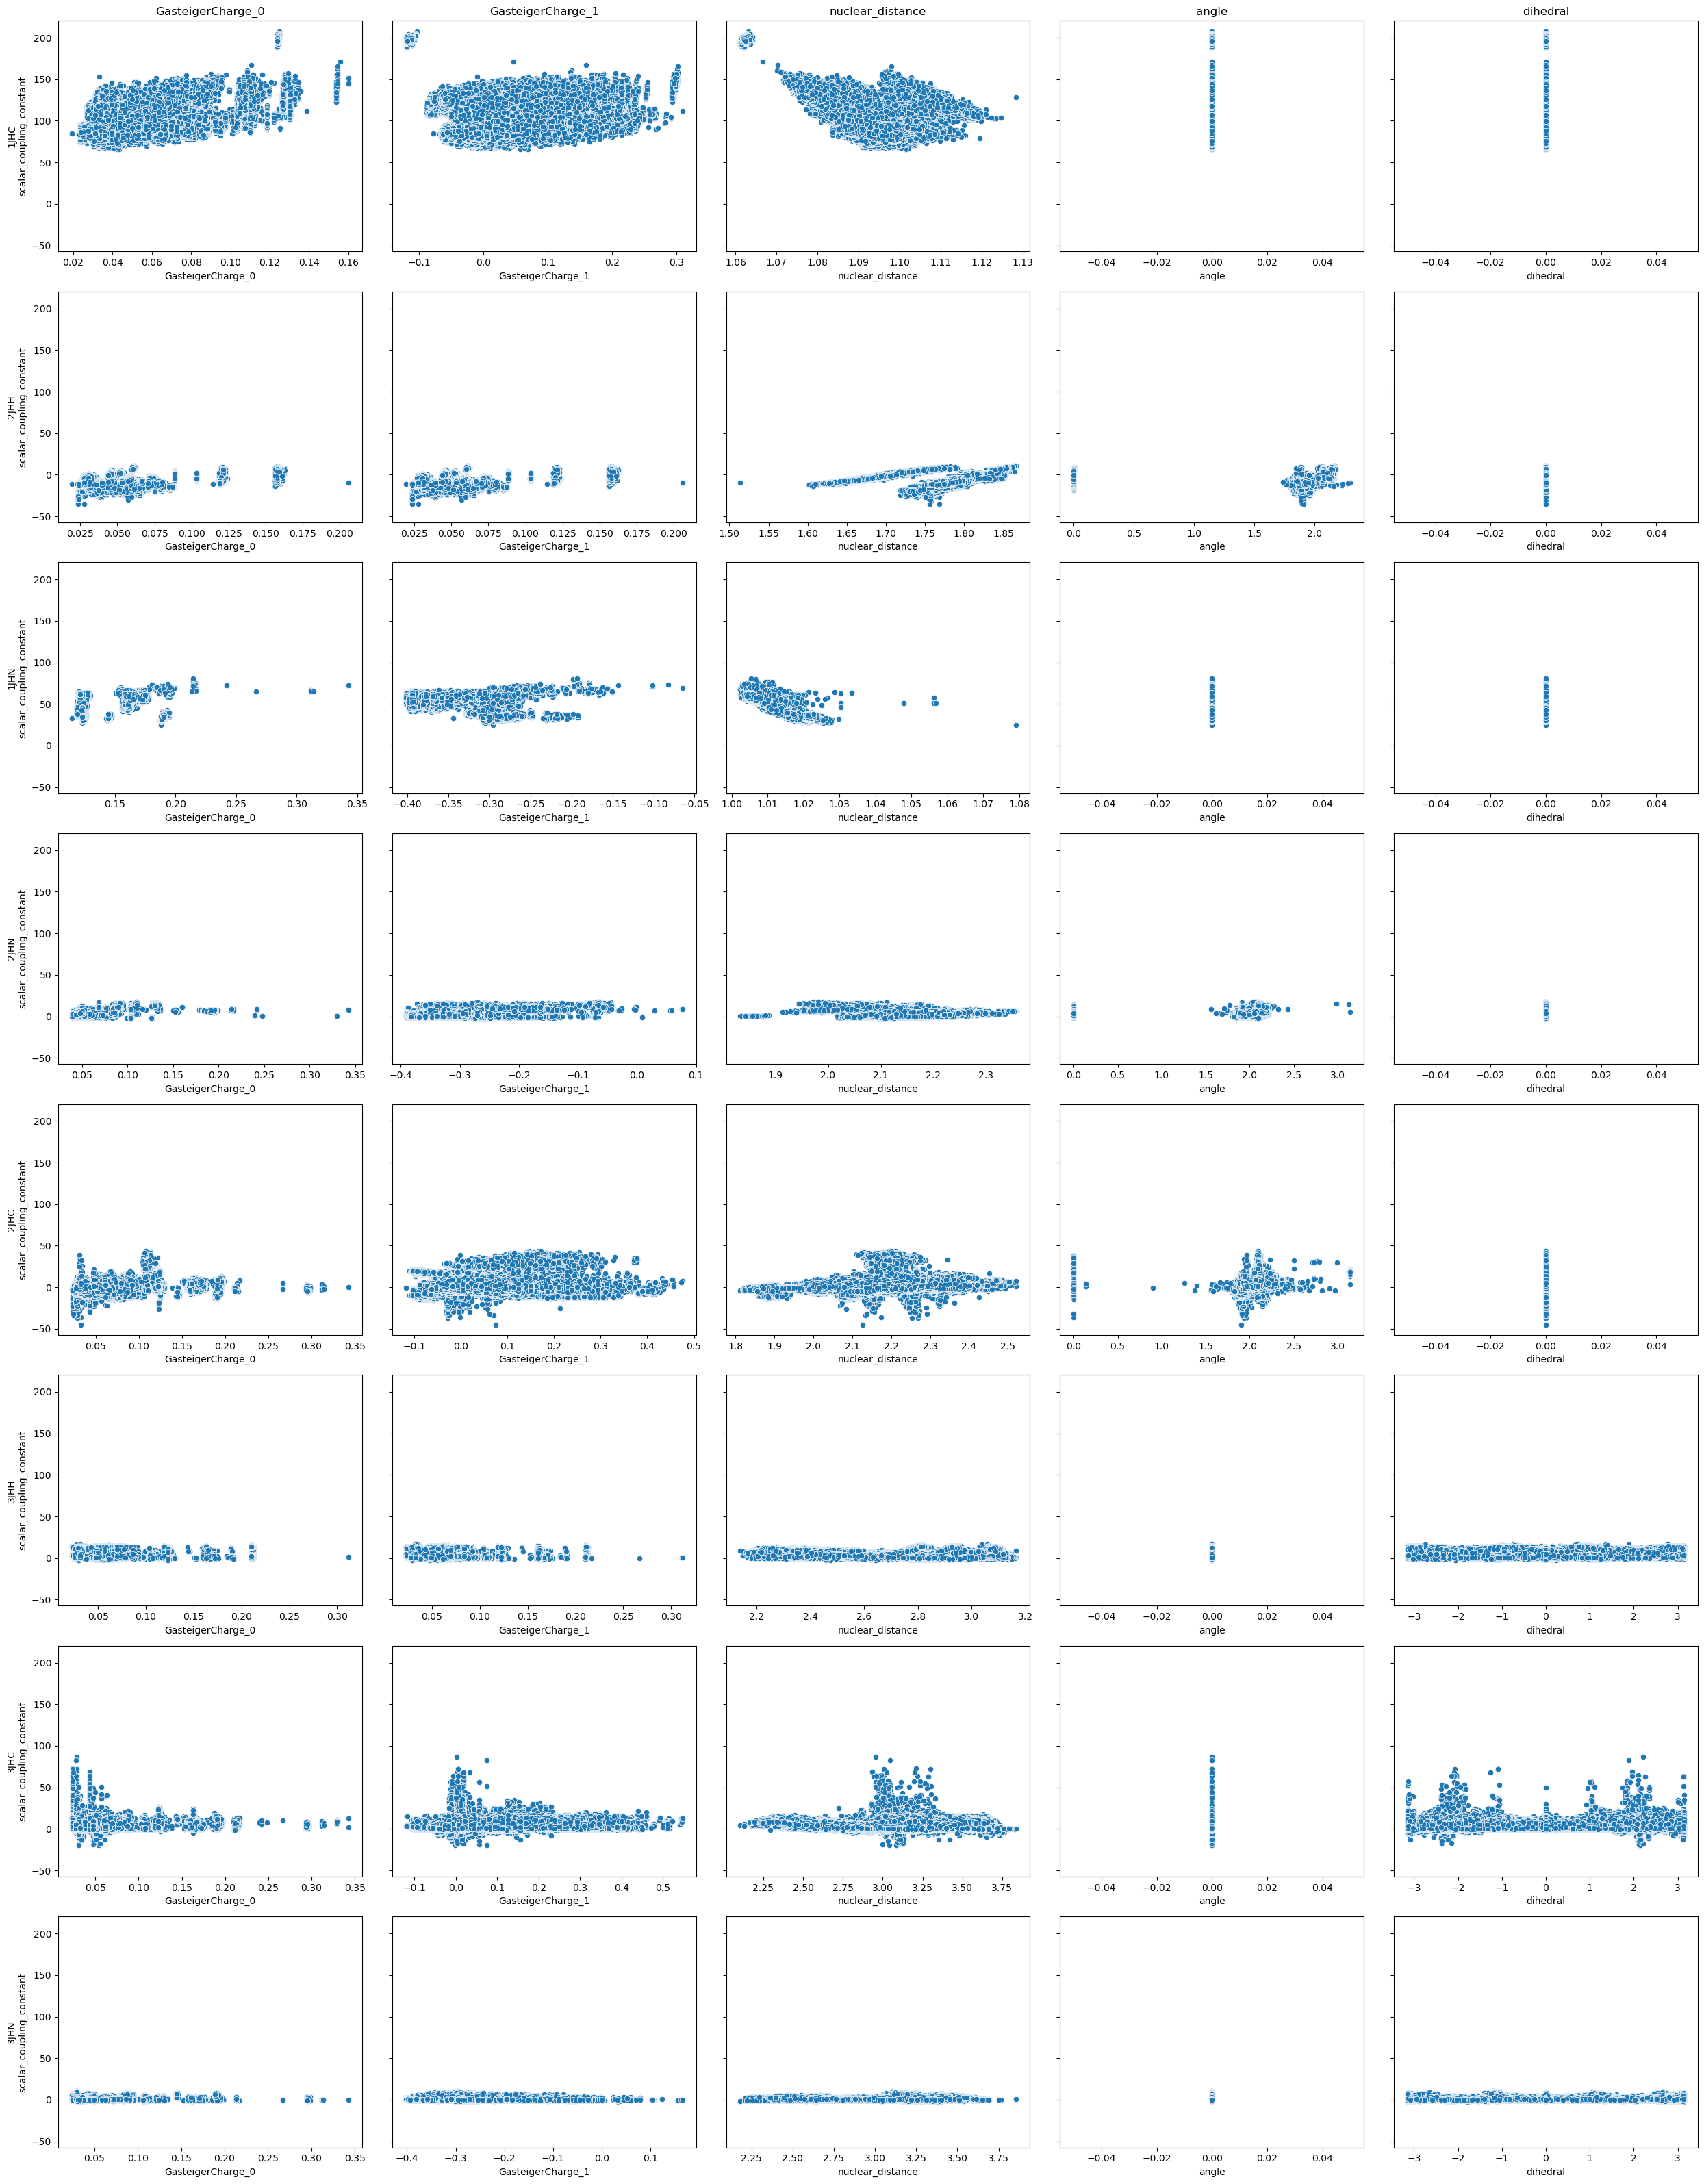

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

types = train_df["type"].unique()
n_cols = len(numerical_cols)
n_rows = len(types)

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(5 * n_cols, 4 * n_rows), sharey=True)

axes = np.array(axes).reshape(n_rows, n_cols)

for row_idx, J_type in enumerate(types):
    for col_idx, column in enumerate(numerical_cols):
        ax = axes[row_idx, col_idx]
        
        
        sns.scatterplot(
            data=train_df[train_df["type"] == J_type],
            x=column,
            y=target_column,
            ax=ax
        )
        
        if row_idx == 0:
            ax.set_title(column)
        if col_idx == 0:
            ax.set_ylabel(f"{J_type}\n{target_column}")
        else:
            ax.set_ylabel('')

        ax.set_xlabel(column)


plt.tight_layout()
plt.show()

In [63]:
numerical_cols = ["GasteigerCharge_0", "GasteigerCharge_1", "nuclear_distance", "angle", "dihedral"]
global_correlations = train_df[numerical_cols + ["scalar_coupling_constant"]].corr()["scalar_coupling_constant"][numerical_cols]
print(global_correlations)

GasteigerCharge_0    0.007345
GasteigerCharge_1   -0.052238
nuclear_distance    -0.667551
angle               -0.378852
dihedral            -0.000624
Name: scalar_coupling_constant, dtype: float64


In [66]:
grouped_correlations = train_df.groupby("type").apply(
    lambda group: group[numerical_cols + ["scalar_coupling_constant"]].corr()["scalar_coupling_constant"][numerical_cols]
)
print(grouped_correlations)

scalar_coupling_constant  GasteigerCharge_0  GasteigerCharge_1  \
type                                                             
1JHC                               0.688409           0.147968   
1JHN                               0.385987          -0.305063   
2JHC                               0.223090          -0.000782   
2JHH                               0.395021           0.395021   
2JHN                               0.374672           0.378402   
3JHC                               0.015657           0.052057   
3JHH                              -0.079937          -0.032407   
3JHN                               0.018596          -0.060566   

scalar_coupling_constant  nuclear_distance     angle  dihedral  
type                                                            
1JHC                             -0.704231       NaN       NaN  
1JHN                             -0.910911       NaN       NaN  
2JHC                              0.288209  0.399044       NaN  
2JHH          